# Single Band Statistics via Sentinel-Hub Statistical API

In [1]:
import os
import yaml
from munch import munchify

### _Setup configuration and environment_

In [2]:
# define repo name and get root working directory
repo = 'statistical'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]

# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-2' )

In [3]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-2' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\statistical\\cfg\\sentinel-2'

In [4]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 's2-band4-histogram.yml' )

In [5]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |       
                //VERSION=3
                function setup() {
                    return {
                        input: [{
                            bands: [
                                "B04",
                                "dataMask"
                            ]
                        }],
                        output: [
                        {
                            id: "output_B04",
                            bands: 1,
                            sampleType: "FLOAT32"
                        },
                        {
                            id: "dataMask",
                            bands: 1
                        } ]
                    }
                }
                function evaluatePixel(samples) {
                    return {
                        output_B04: [samples.B04],
                        dataMask: [samples.dataMask]
                    }
                }    
    inputs:
        - collection: SENTIN

In [6]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )
config

Munch({'request': Munch({'evalscript': '//VERSION=3\nfunction setup() {\n    return {\n        input: [{\n            bands: [\n                "B04",\n                "dataMask"\n            ]\n        }],\n        output: [\n        {\n            id: "output_B04",\n            bands: 1,\n            sampleType: "FLOAT32"\n        },\n        {\n            id: "dataMask",\n            bands: 1\n        } ]\n    }\n}\nfunction evaluatePixel(samples) {\n    return {\n        output_B04: [samples.B04],\n        dataMask: [samples.dataMask]\n    }\n}    \n', 'inputs': [Munch({'collection': 'SENTINEL2_L2A', 'mosaic': Munch({'order': 'leastRecent'})})]}), 'responses': Munch({'default': Munch({'histograms': Munch({'default': Munch({'nBins': 5, 'lowEdge': 0.0, 'highEdge': 0.3})}), 'statistics': Munch({'default': Munch({'percentiles': Munch({'k': [33, 50, 75, 90]})})})})})})

### _Replicate use case results taken from Sentinel-Hub documentation_

In [7]:
from sentinelhub import CRS

# define min and max latlons
coords = 414315, 4958219, 414859, 4958819
crs = CRS( 32633 )

resolution = 10

In [8]:
# define aggregation timeframe
from datetime import datetime
timeframe = { 'start' : datetime.strptime('2020-07-04', '%Y-%m-%d'), 
              'end' : datetime.strptime('2020-07-05', '%Y-%m-%d') }

In [9]:
# create instance of shclient class
from statisticalapi import Client
client = Client( config )

In [10]:
# get utm bbox
bbox = client.getBoundingBox( coords, src_crs=crs )
print ( bbox, bbox.crs.value )

414315.0,4958219.0,414859.0,4958819.0 32633


In [11]:
# submit request
response = client.getStatistics( [ timeframe ], resolution=resolution, bbox=bbox )

In [12]:
response._dfs[ 0 ]

,id,interval_from,interval_to,output_B04_B0_min,output_B04_B0_max,output_B04_B0_mean,output_B04_B0_stDev,output_B04_B0_sampleCount,output_B04_B0_noDataCount,output_B04_B0_percentiles_33.0,output_B04_B0_percentiles_50.0,output_B04_B0_percentiles_75.0,output_B04_B0_percentiles_90.0,output_B04_B0_histogram
0,geom_0,2020-07-04,2020-07-05,0.0797,0.3096,0.114711,0.034298,3240,0,0.0971,0.1036,0.1194,0.1604,"{'bins': [{'lowEdge': 0.0, 'highEdge': 0.06, '..."


{'data': [{'interval': {'from': '2020-07-04T00:00:00Z',
    'to': '2020-07-05T00:00:00Z'},
   'outputs': {'output_B04': {'bands': {'B0': {'stats': {'min': 0.07970000058412552,
        'max': 0.30959999561309814,
        'mean': 0.11471141986778864,
        'stDev': 0.034298170449733226,
        'sampleCount': 3240,
        'noDataCount': 0,
        'percentiles': {'33.0': 0.09709999710321426,
         '50.0': 0.10360000282526016,
         '75.0': 0.11940000206232071,
         '90.0': 0.16040000319480896}},
       'histogram': {'bins': [{'lowEdge': 0.0, 'highEdge': 0.06, 'count': 0},
         {'lowEdge': 0.06, 'highEdge': 0.12, 'count': 2458},
         {'lowEdge': 0.12, 'highEdge': 0.18, 'count': 558},
         {'lowEdge': 0.18, 'highEdge': 0.24, 'count': 177},
         {'lowEdge': 0.24, 'highEdge': 0.3, 'count': 44}],
        'overflowCount': 0,
        'underflowCount': 3}}}}}}],
 'status': 'OK'}

### _Quick plot of normalised histogram counts_

<BarContainer object of 5 artists>

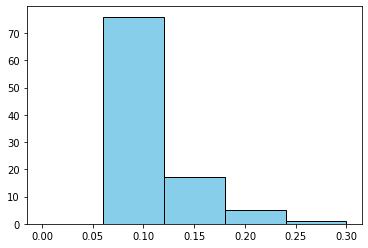

In [13]:
import matplotlib.pyplot as plt
import numpy as np

hist = response._dfs[ 0 ].iloc[ 0 ][ 'output_B04_B0_histogram' ]
plt.bar(x=hist['bin_edges'][:-1], height=hist['normalised_counts'], width=np.diff(hist['bin_edges']), align='edge', fc='skyblue', ec='black')


### _Repeat Statistical API request for two months with 10 days aggregation period_

In [14]:
timeframe = { 'start' : datetime.strptime('2020-06-01', '%Y-%m-%d'), 
              'end' : datetime.strptime('2020-07-31', '%Y-%m-%d') }

In [15]:
# submit request
response = client.getStatistics( [ timeframe ], resolution=10, bbox=bbox, interval='P10D' )

In [16]:
response._dfs[ 0 ]

,id,interval_from,interval_to,output_B04_B0_min,output_B04_B0_max,output_B04_B0_mean,output_B04_B0_stDev,output_B04_B0_sampleCount,output_B04_B0_noDataCount,output_B04_B0_percentiles_33.0,output_B04_B0_percentiles_50.0,output_B04_B0_percentiles_75.0,output_B04_B0_percentiles_90.0,output_B04_B0_histogram
0,geom_0,2020-06-01,2020-06-11,0.7892,0.8304,0.804224,0.006707,3240,0,0.8008,0.8028,0.8076,0.8140,"{'bins': [{'lowEdge': 0.0, 'highEdge': 0.06, '..."
1,geom_0,2020-06-11,2020-06-21,0.0163,0.5956,0.062401,0.062665,3240,0,0.0297,0.0398,0.0680,0.1354,"{'bins': [{'lowEdge': 0.0, 'highEdge': 0.06, '..."
2,geom_0,2020-06-21,2020-07-01,0.0260,0.4380,0.068724,0.056520,3240,0,0.0423,0.0458,0.0684,0.1410,"{'bins': [{'lowEdge': 0.0, 'highEdge': 0.06, '..."
3,geom_0,2020-07-01,2020-07-11,0.0797,0.3096,0.114711,0.034298,3240,0,0.0971,0.1036,0.1194,0.1604,"{'bins': [{'lowEdge': 0.0, 'highEdge': 0.06, '..."
4,geom_0,2020-07-11,2020-07-21,0.0174,0.4188,0.062195,0.063177,3240,0,0.0302,0.0343,0.0639,0.1464,"{'bins': [{'lowEdge': 0.0, 'highEdge': 0.06, '..."
5,geom_0,2020-07-21,2020-07-31,0.1392,0.4928,0.314640,0.054701,3240,0,0.2880,0.3108,0.3506,0.3842,"{'bins': [{'lowEdge': 0.0, 'highEdge': 0.06, '..."


{'data': [{'interval': {'from': '2020-06-01T00:00:00Z',
    'to': '2020-06-11T00:00:00Z'},
   'outputs': {'output_B04': {'bands': {'B0': {'stats': {'min': 0.7892000079154968,
        'max': 0.8303999900817871,
        'mean': 0.804223583473102,
        'stDev': 0.0067066009561434865,
        'sampleCount': 3240,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2020-06-11T00:00:00Z', 'to': '2020-06-21T00:00:00Z'},
   'outputs': {'output_B04': {'bands': {'B0': {'stats': {'min': 0.016300000250339508,
        'max': 0.5956000089645386,
        'mean': 0.06240126554233315,
        'stDev': 0.06266500670629409,
        'sampleCount': 3240,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2020-06-21T00:00:00Z', 'to': '2020-07-01T00:00:00Z'},
   'outputs': {'output_B04': {'bands': {'B0': {'stats': {'min': 0.026000000536441803,
        'max': 0.43799999356269836,
        'mean': 0.06872379640174772,
        'stDev': 0.056520330692016944,
        'sampleCount': 3240,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2020-07-01T00:00:00Z', 'to': '2020-07-11T00:00:00Z'},
   'outputs': {'output_B04': {'bands': {'B0': {'stats': {'min': 0.07970000058412552,
        'max': 0.30959999561309814,
        'mean': 0.11471141986778864,
        'stDev': 0.034298170449733226,
        'sampleCount': 3240,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2020-07-11T00:00:00Z', 'to': '2020-07-21T00:00:00Z'},
   'outputs': {'output_B04': {'bands': {'B0': {'stats': {'min': 0.017400000244379044,
        'max': 0.4187999963760376,
        'mean': 0.062194598779473156,
        'stDev': 0.06317700445712106,
        'sampleCount': 3240,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2020-07-21T00:00:00Z', 'to': '2020-07-31T00:00:00Z'},
   'outputs': {'output_B04': {'bands': {'B0': {'stats': {'min': 0.13920000195503235,
        'max': 0.4927999973297119,
        'mean': 0.3146395680115182,
        'stDev': 0.054700527707146035,
        'sampleCount': 3240,
        'noDataCount': 0}}}}}}],
 'status': 'OK'}